# Model evaluation with Cross Validation

Model testing with cross validation suggests a Random Forest Regressor with a buffer size of 500m is the best performing.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
# import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
# from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil
import io
from PIL import Image

from Functions import *

## Define random forest model pipeline
(This was found to be best model)

In [2]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

## Produce data in the correct format for the CV process

#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes

In [3]:
buffer_size_m=400
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
# Store the date time colums to allow segregation of the results by date and time later in the script 
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [4]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']

### Remove year

In [5]:
del Xfull['year']

### Choose which month_num and weekday_num option to include
Drop one version of the time variables (either cyclical or dummy versions)

In [6]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [7]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

In [25]:
#### Run cross_val_predict to get predictions
start = time()
predictions = cross_val_predict(rf_model_pipeline, Xfull, Yfull,cv=cv_parameters)
end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))
# Convert to a dataframe
predictions_df=pd.DataFrame(predictions)
# Store the predictions
predictions_df.to_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m),index=False)   

Ran cross_val_predict in 172 minutes


In [8]:
predictions = pd.read_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m))["0"]

### Plot the predicted vs actual values from the CV process
Within cross validation each data point is included in the test set only once and thus despite their beng multiple cross-validation folds, each true value of Y has only one associated prediction 

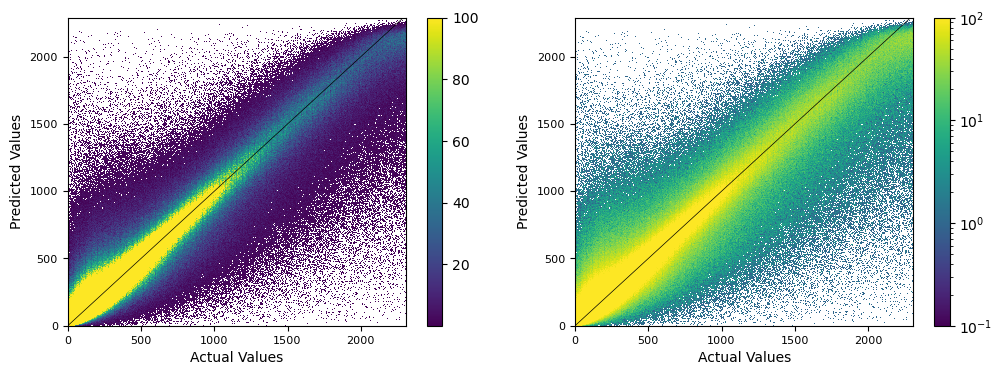

In [9]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

## Find the error in the predictions broken down by hour and sensor

In [10]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': predictions, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num'] ,'sensor_id':sensor_ids, 'AbsolouteError':abs(Yfull-predictions),
                 'Error':Yfull-predictions, 'datetime':data_time_columns['datetime']})
# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

df['Percentage_Difference']= abs(df['Real_vals'] - df['Predictions'])/((df['Real_vals'] + df['Predictions'])/2)* 100
df['Percentage_Increase']= ((df['Real_vals'] - df['Predictions']) / abs(df['Predictions'])) * 100

In [11]:
df["datetime"]  = pd.to_datetime(df["datetime"] , errors='coerce')

In [12]:
def MAPE(Y_actual,Y_Predicted):
    try:
        mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    except:
        mape = np.nan
    return mape

df['Mape']  = df.apply(lambda x: MAPE(x['Real_vals'], x['Predictions']), axis=1)

In [13]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))
    
# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

### Plot the errors per hour of week

In [14]:
labels = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12',
         '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12',]*7

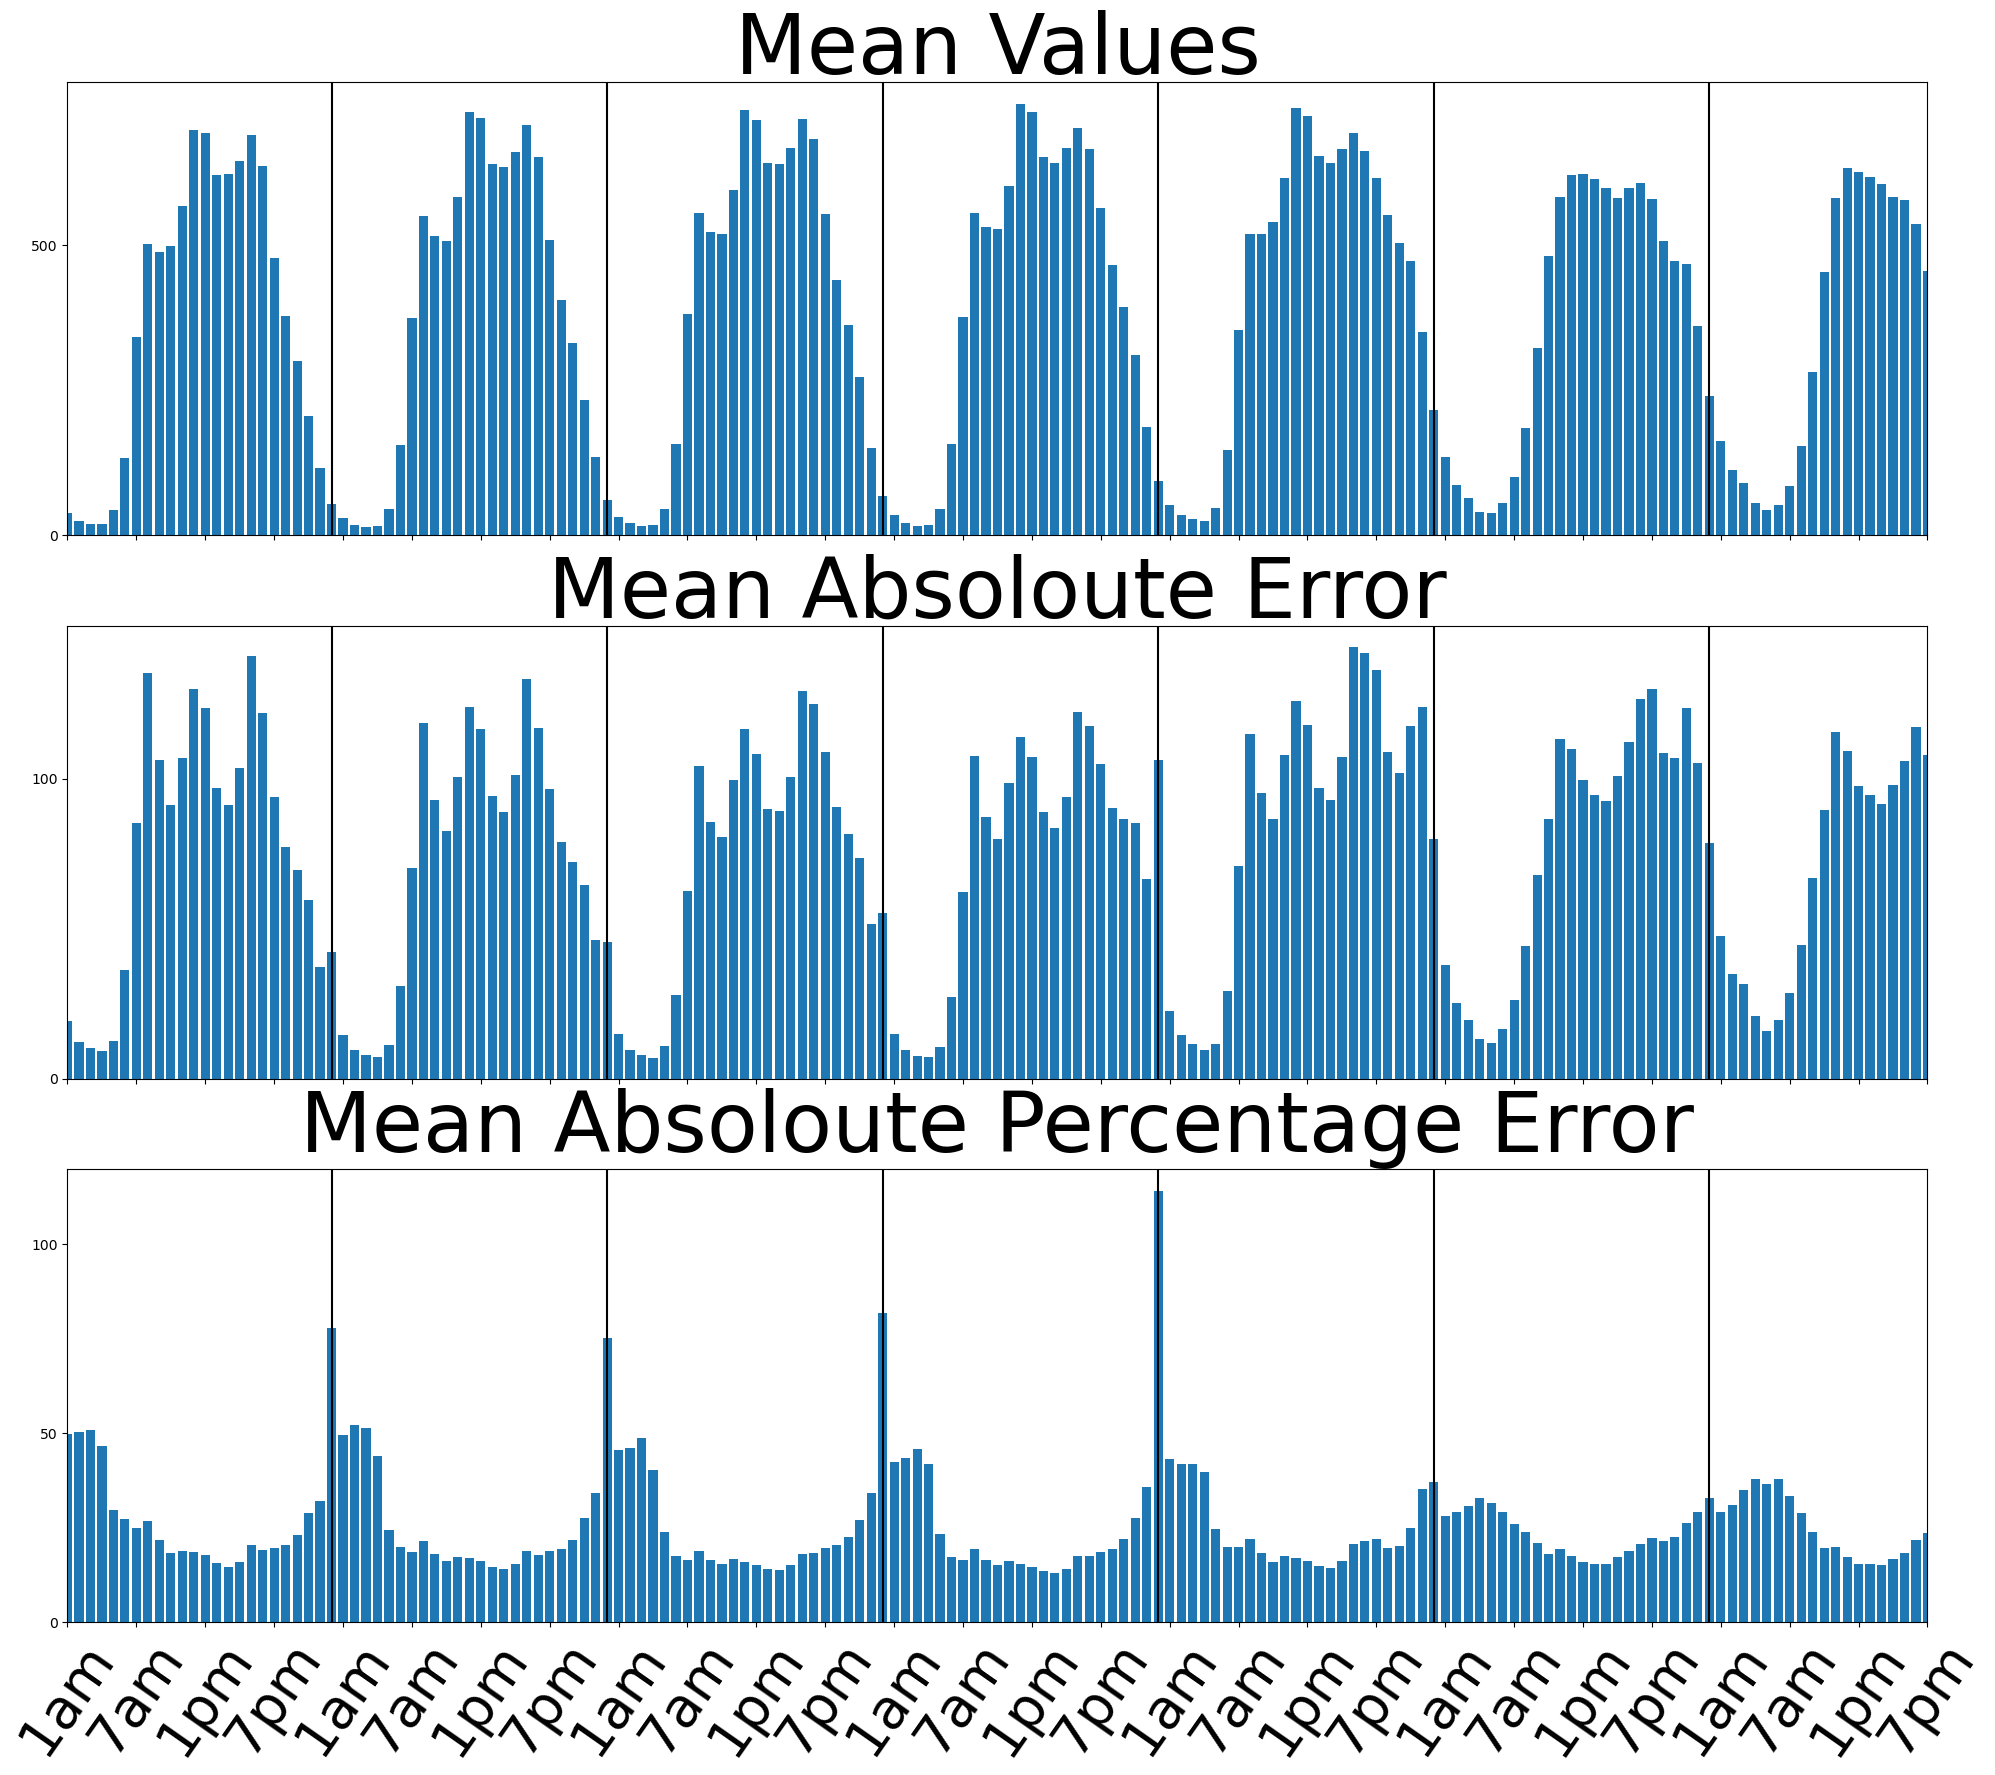

In [15]:
fig,axs =plt.subplots(nrows=3,figsize =(24,20), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means)#,  yerr=hourofweekly_stds  )
axs[0].set_title('Mean Values', fontsize=60)
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes)#, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error', fontsize=60)
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[2].set_title('Mean Absoloute Percentage Error', fontsize=60)
# axs[2].tick_params(axis='x')

# Removes weird whitespace from the start
axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::3])])

# Axis labels
axs[2].set_xticks(list(range(1,len(labels)))[::6], fontsize=40)
axs[2].set_xticklabels(labels[::6], fontsize=40, rotation = 55)

params = {'ytick.labelsize': 50}
plt.rcParams.update(params)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    
fig.savefig('Results/Figs/ModelEvaluation_withCV/Error_by_hour_of_week.pdf')
fig.savefig('Results/Figs/ModelEvaluation_withCV/Error_by_hour_of_week.jpg')

### Plot errors by hour of day

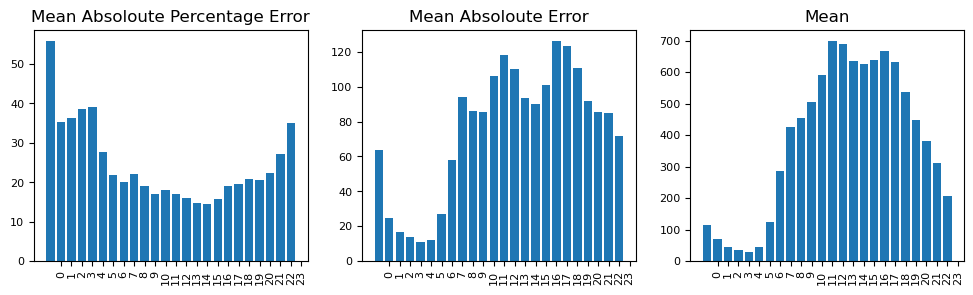

In [16]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error');
axs[1].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[2].set_title('Mean')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

axs[2].tick_params(axis='y', which='major', labelsize=8)
axs[0].tick_params(axis='y', which='major', labelsize=8)
axs[1].tick_params(axis='y', which='major', labelsize=8)

### Plot the errors by sensor

In [1]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

NameError: name 'pd' is not defined

In [ ]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

### MEAN

In [23]:
linear = cm.linear.viridis.scale(melbourne_sensors['Mean'].min(),melbourne_sensors['Mean'].max()).to_step(7)
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)

for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.Mean), fill_color = linear(row.Mean),
                      ).add_to(melbourne_map)

# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_mean.png')

melbourne_map

### MAPE

In [24]:
linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAPE'].min(), vmax=melbourne_sensors['MAPE'].max())
linear = cm.linear.viridis.scale(melbourne_sensors['MAPE'].min(),melbourne_sensors['MAPE'].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAPE), fill_color = linear(row.MAPE),
                      ).add_to(melbourne_map)

# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)


img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_MAPE.png')
melbourne_map

### MAE

In [25]:
# linear = cm.LinearColormap(["green", "yellow", "red"], vmin=melbourne_sensors['MAE'].min(), vmax=melbourne_sensors['MAE'].max())
linear = cm.linear.viridis.scale(melbourne_sensors['MAE'].min(),melbourne_sensors['MAE'].max()).to_step(7)

# Plot
f = folium.Figure(width=700, height=600)
# Plot
melbourne_map = folium.Map(location=[melbourne_sensors.Latitude.mean(),
                           melbourne_sensors.Longitude.mean()], zoom_start=14, control_scale=True, min_zoom = 13).add_to(f)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
for _, row in melbourne_sensors.iterrows():
    folium.CircleMarker([row.Latitude, row.Longitude],
                      popup=row.sensor_id,
                      radius=8,  fill=True, fill_opacity = 1,
                      color = linear(row.MAE), fill_color = linear(row.MAE),
                      ).add_to(melbourne_map)


# folium.TileLayer('stamentoner').add_to(melbourne_map)
folium.TileLayer('cartodbpositron').add_to(melbourne_map)
linear.caption = "Mean hourly values"
svg_style = '<style>svg#legend {background-color: white;}</style>'
melbourne_map.get_root().header.add_child(folium.Element(svg_style))
linear.add_to(melbourne_map)

img_data = melbourne_map._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('Results/Figs/SpatialErrors_MAE.png')
melbourne_map

In [66]:
df = df.replace([np.inf, -np.inf], np.nan)
df.sort_values('Mape', ascending=False, na_position='last').head()

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Difference,Percentage_Increase,Mape
1392098,2019.70,1,18,5,2,2018.70,-2018.70,2017-01-20 18:00:00,w5_h18,199.802049,-99.950488,201870.0
1392118,1534.30,1,19,5,2,1533.30,-1533.30,2017-01-20 19:00:00,w5_h19,199.739465,-99.934824,153330.0
34454,1297.47,1,13,5,13,1296.47,-1296.47,2011-04-01 13:00:00,w5_h13,199.691945,-99.922927,129647.0
1392183,1181.69,1,21,5,1,1180.69,-1180.69,2017-01-20 21:00:00,w5_h21,199.661788,-99.915375,118069.0
860301,1056.92,1,19,2,32,1055.92,-1055.92,2015-06-16 19:00:00,w2_h19,199.621900,-99.905385,105592.0


In [65]:
df.sort_values('Error', ascending=False, na_position='last').head()

,Predictions,Real_vals,Hour,Weekday,sensor_id,AbsolouteError,Error,datetime,hour_of_week,Percentage_Difference,Percentage_Increase,Mape
813830,50.46,2265,5,6,28,2214.54,2214.54,2015-04-25 05:00:00,w6_h5,191.282942,4388.703924,97.772185
3647131,95.97,2302,22,3,57,2206.03,2206.03,2021-12-29 22:00:00,w3_h22,183.991459,2298.666250,95.831017
763189,60.05,2265,4,7,28,2204.95,2204.95,2015-02-22 04:00:00,w7_h4,189.669039,3671.856786,97.348786
763165,50.78,2246,4,7,7,2195.22,2195.22,2015-02-22 04:00:00,w7_h4,191.156314,4323.001182,97.739092
3635919,121.13,2296,22,3,57,2174.87,2174.87,2021-12-22 22:00:00,w3_h22,179.954740,1795.484191,94.724303
